<img src="https://raw.githubusercontent.com/earthdaily/Images/main/Corporate/EarthDaily.png" width="20%" alt="EarthDaily Analytics">

# Getting Started with EarthDaily
__________________
<a href="https://earthdaily.com/contact/">Give Feedback</a> | <a href="https://github.com/earthdaily">Bug report</a>

**Tags:** #EDS, #EarthMosaics, #EarthDailyConstellation, #EDC, #Sentinel-2, #VENuS, #Landsat, #STAC, #ODC

**Authors**: EarthDaily Analytics

**Last update:** 2024-02-11 (Created: 2024-12-17)

**References:**
- [EarthDaily package](https://github.com/earthdaily/earthdaily-python-client)
- [Earth Data Store documentation](https://earthdaily.github.io/EDA-Documentation/)

## Introduction
EarthDaily Analytics offers access to several [STAC-compliant](https://stacspec.org/en) catalogs of raster data, such as [EarthMosaics](https://earthdaily.com/product-service/earthmosaics/) and [VENuS](https://earthdaily.com/earthdaily-ven%C2%B5s-l2a-cloud-optimized-geotiffs/), as well as maintains development of the [EarthDaily Python Client](https://pypi.org/project/earthdaily/), which acts as a user-friendly access interface to retrieve pixel data as [xarray](https://docs.xarray.dev/en/stable/) objects.

## Objectives
This document explores the basics of accessing and analyzing data hosted by EarthDaily. By the end of this notebook, we will have:
* Authenticated a connection to the STAC-compliant Earth Data Store
* Listed available collections
* Searched for image data over specified areas of interest (AOIs)
* Retrieved image data as an n-dimensional array

#### _Note_
_Most examples contained in this repository use the EarthDaily Python client to search and access image data. If you prefer to use PySTAC and ODC directly, we outline examples of these access patterns in this notebook._

Import dependencies

In [1]:
import earthdaily
from earthdaily import EarthDataStore

In [2]:
import os
import requests

import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr

from dotenv import load_dotenv
from odc.stac import stac_load
from shapely.geometry import box

import matplotlib.pyplot as plt

## Connecting to EarthDataStore

Loading in environment variables, please update the associated [`EDS.env`](EDS.env), which can be downloaded from the [EarthDaily Account Management page](https://console.earthdaily.com/account).

In [3]:
load_dotenv("EDS.env")

True

> _**Note:**_ To gain access to the Earth Data Store data used in this example, please [create an EarthDaily account](https://console.earthdaily.com/mosaics/signup)

Next, instantiate a connection to the Earth Data Store:

In [4]:
eds = EarthDataStore()

Listing available Collections via `eds.explore()`:

In [5]:
eds.explore()

['ai-ready-mosaics',
 'ai-ready-mosaics-preview',
 'ai-ready-mosaics-sample',
 'cropland-data-layer-us',
 'earthdaily-simulated-cloudless-l2a-cog-edagro',
 'landsat-c2l1',
 'landsat-c2l2-sr',
 'landsat-c2l2-st',
 'sentinel-1-grd',
 'sentinel-1-rtc',
 'sentinel-2-c1-l2a',
 'sentinel-2-l1c',
 'sentinel-2-l2a',
 'venus-l2a']

### _Connecting via PySTAC_
If you prefer to access data via the [PySTAC Client](https://pystac-client.readthedocs.io/en/stable/), you can retrieve an active bearer token and connect as follows:

> _**Note:**_ Here we import a small utility function to retrieve an active access token.

In [6]:
from utils import get_new_token

In [7]:
from pystac_client import Client

CLIENT_ID = os.getenv("EDS_CLIENT_ID")
CLIENT_SECRET = os.getenv("EDS_SECRET")
AUTH_TOKEN_URL = os.getenv("EDS_AUTH_URL")
API_URL = os.getenv("EDS_API_URL")

session = requests.Session()
session.auth = (CLIENT_ID, CLIENT_SECRET)
token = get_new_token(session, AUTH_TOKEN_URL)

catalog = Client.open(
    API_URL,
    headers={"Authorization": f"bearer: {token}"}
)

list(catalog.get_collections())

[<Collection id=ai-ready-mosaics>,
 <Collection id=ai-ready-mosaics-preview>,
 <Collection id=ai-ready-mosaics-sample>,
 <Collection id=cropland-data-layer-us>,
 <Collection id=earthdaily-simulated-cloudless-l2a-cog-edagro>,
 <Collection id=landsat-c2l1>,
 <Collection id=landsat-c2l2-sr>,
 <Collection id=landsat-c2l2-st>,
 <Collection id=sentinel-1-grd>,
 <Collection id=sentinel-1-rtc>,
 <Collection id=sentinel-2-c1-l2a>,
 <Collection id=sentinel-2-l1c>,
 <Collection id=sentinel-2-l2a>,
 <Collection id=venus-l2a>]

## Image Queries

Let's construct a query to retrieve EarthMosaic Sample image collections which correspond to a defined bounding box and start/end dates. 

Here we'll define an input bounding box to search, start date, and end date:

In [8]:
bbox = [-52.38175462, -29.85496458, -52.07547469, -29.61356083]
start_date = "2024-02-01"
end_date = "2024-12-01"

Querying Venus L2A collection to find items matching our input AOI, date range, and property filter:

> _**Note:**_ Here we import a small utility function which replaces S3 HREFs with public HTTPS URLs.

In [9]:
from utils import replace_alternate_href

In [10]:
items = eds.search(
    collections=["ai-ready-mosaics-sample"],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox
)
# Apply href function
[replace_alternate_href(item) for item in items]
print(f'Found unique {len(items)} items')
items

Found unique 2 items


#### _Image Queries in PySTAC_

In [11]:
query = catalog.search(
    collections=["ai-ready-mosaics-sample"],
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
)
print(f'Found unique {len(list(query.items()))} items')

Found unique 2 items


## Data Retrieval
Now that there's a reference to a list of items from the catalog, we can use [`odc.stac.load`](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html) to retrieve associated bands as an [`xarray Dataset`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html):

In [12]:
dataset = earthdaily.earthdatastore.datacube(
    items,
    assets=("red", "green", "blue"),
    intersects=gpd.GeoDataFrame(
        {'geometry':[box(*bbox)]}, 
        crs='epsg:4326'
    ),
    crs="epsg:3857", 
    resolution=10.,
    bbox=bbox,
    chunks={"x": 2048, "y": 2048},
)
dataset

<xarray.Dataset> Size: 253MB
Dimensions:      (y: 3095, x: 3409, time: 2)
Coordinates:
  * y            (y) float64 25kB -3.454e+06 -3.454e+06 ... -3.485e+06
  * x            (x) float64 27kB -5.831e+06 -5.831e+06 ... -5.797e+06
  * time         (time) datetime64[ns] 16B 2024-02-21T13:40:29.936000 2024-05...
    spatial_ref  int64 8B 0
Data variables:
    red          (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    green        (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>
    blue         (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2047), meta=np.ndarray>

#### _Data Retrieval with PySTAC using ODC_

In [13]:
stac_load(
    items,
    bands=("red", "green", "blue"),
    crs="epsg:3857", 
    resolution=10., 
    chunks={"x": 2048, "y": 2048},
    groupby="id",
    bbox=bbox
)

<xarray.Dataset> Size: 254MB
Dimensions:      (y: 3096, x: 3411, time: 2)
Coordinates:
  * y            (y) float64 25kB -3.454e+06 -3.454e+06 ... -3.485e+06
  * x            (x) float64 27kB -5.831e+06 -5.831e+06 ... -5.797e+06
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 16B 2024-02-21T13:40:29.936000 2024-05...
Data variables:
    red          (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    blue         (time, y, x) float32 84MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>

Lastly, we'll inspect an image within our stack:

> _**Note:**_ Here we import a small utility function which applies a linear 2% stretch to the RGB data for visualization.

In [14]:
from utils import linear_stretch_rgb

In [15]:
rgb_ds = dataset.isel(time=0)
rgb_arr = np.stack(
    [rgb_ds['red'], rgb_ds['green'], rgb_ds['blue']],
    axis=-1
)
# Apply a linear 2% stretch for visualization
rgb_arr = linear_stretch_rgb(rgb_arr)

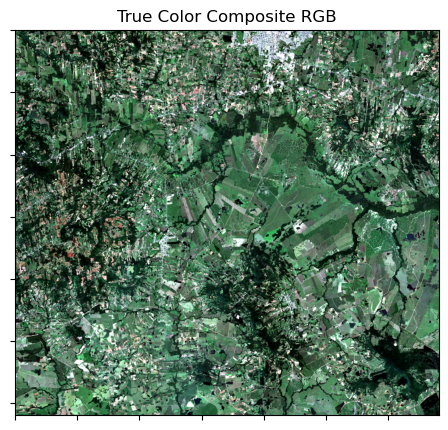

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.imshow(rgb_arr)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.title("True Color Composite RGB")
plt.show()

#### Saving Data Locally

In [17]:
rgb_ds.rio.to_raster("output.tif")

#### _Cleaning Up_

In [18]:
os.remove("output.tif")